# Assignment 2

## Instructions
- Your submission should be the `.ipynb` file with your name,
  like `YusufMesbah.ipynb`. it should include the answers to the questions in
  markdown cells.
- You are expected to follow the best practices for code writing and model
training. Poor coding style will be penalized.
- You are allowed to discuss ideas with your peers, but no sharing of code.
Plagiarism in the code will result in failing. If you use code from the
internet, cite it.
- If the instructions seem vague, use common sense.

# Task 1: ANN (30%)
For this task, you are required to build a fully connect feed-forward ANN model
for a multi-label regression problem.

For the given data, you need do proper data preprocessing, design the ANN model,
then fine-tune your model architecture (number of layers, number of neurons,
activation function, learning rate, momentum, regularization).

For evaluating your model, do $80/20$ train test split.

### Data
You will be working with the data in `Task 1.csv` for predicting students'
scores in 3 different exams: math, reading and writing. The columns include:
 - gender
 - race
 - parental level of education
 - lunch meal plan at school
 - whether the student undertook the test preparation course

# Sergeev Nikita BS20-AI-01

In [131]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
import torch.utils.data as data_utils
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from torchvision.transforms import transforms
from torchvision import datasets
import torchvision
import torchsummary
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [132]:
df = pd.read_csv('Task 1.csv')
df.head()

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,male,group A,high school,standard,completed,67,67,63
1,female,group D,some high school,free/reduced,none,40,59,55
2,male,group E,some college,free/reduced,none,59,60,50
3,male,group B,high school,standard,none,77,78,68
4,male,group E,associate's degree,standard,completed,78,73,68


In [133]:
df.describe()

,math score,reading score,writing score
count,1000.000000,1000.000000,1000.000000
mean,66.396000,69.002000,67.738000
std,15.402871,14.737272,15.600985
min,13.000000,27.000000,23.000000
25%,56.000000,60.000000,58.000000
50%,66.500000,70.000000,68.000000
75%,77.000000,79.000000,79.000000
max,100.000000,100.000000,100.000000


# Data preprocessing

In [134]:
y = df[['math score', 'reading score', 'writing score']] # target features
X = df.drop(['math score', 'reading score', 'writing score'], axis=1) # features
X = pd.get_dummies(X) # one-hot encoding for categorical features
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) # 80/20 train test split
X_train.shape, y_train.shape

((800, 17), (800, 3))

# Pytorch architecture of the Neural Network

In [135]:
class ANN(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size, regression):
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1) # first hidden layer
        self.fc2 = nn.Linear(hidden_size1, hidden_size2) # second hidden layer
        self.fc3 = nn.Linear(hidden_size2, output_size) # output layer
        self.regression = regression # regression or classification task

    def forward(self, x):
        # I used ReLU activation function for hidden layers and identity function for output layer.
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        if not self.regression:
            # classification task → apply softmax function.
            x = F.log_softmax(x, dim=1)
        return x

In [136]:
# Convert data to pytorch tensors
X_train = torch.tensor(X_train.values, dtype=torch.float32)
y_train = torch.tensor(y_train.values, dtype=torch.float32)
X_test = torch.tensor(X_test.values, dtype=torch.float32)
y_test = torch.tensor(y_test.values, dtype=torch.float32)
X_train.shape, y_train.shape

(torch.Size([800, 17]), torch.Size([800, 3]))

# Train keras model (for comparing its performance with pytorch model)

In [137]:
import tensorflow as tf
from tensorflow import keras
from keras import layers

# model architecture
logreg = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    layers.Dense(64, activation='relu'),
    layers.Dense(3)
])

# compile model with MSE loss function and Adam optimizer
logreg.compile(optimizer='adam',
              loss='mse')

# convert pytorch tensors to tensorflow tensors
tf_X_train = tf.convert_to_tensor(X_train.numpy())
tf_y_train = tf.convert_to_tensor(y_train.numpy())
tf_X_test = tf.convert_to_tensor(X_test.numpy())
tf_y_test = tf.convert_to_tensor(y_test.numpy())

# train model and output its performance on validation set
logreg.fit(tf_X_train, tf_y_train, epochs=100, batch_size=32, verbose=0)
val_score = logreg.evaluate(tf_X_test, tf_y_test, verbose=0)
print('MSE of the training set: ', val_score)

MSE of the training set:  170.05230712890625


## Define parameters for training Pytorch model

In [138]:
# define model parameters
model = ANN(X_train.shape[1], 64, 64, y_train.shape[1], regression=True)

epochs = 500 # number of epochs
criterion = nn.MSELoss() # loss function
lr = 0.001 # learning rate
optimizer = torch.optim.Adam(model.parameters(), lr=lr) # use Adam optimizer
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=250, gamma=0.5) # learning rate scheduler with step size 250 and gamma 0.5

In [139]:
# model summary
torchsummary.summary(model, (X_train.shape[1],), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 64]           1,152
            Linear-2                   [-1, 64]           4,160
            Linear-3                    [-1, 3]             195
Total params: 5,507
Trainable params: 5,507
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.02
Estimated Total Size (MB): 0.02
----------------------------------------------------------------


In [140]:
# Early stopping the training process.
# (if validation loss doesn't decrease for 10 epochs)
def early_stopping(loss, patience=10):
    if len(loss) < patience:
        return False
    for i in range(1, patience):
        if loss[-i] < loss[-i-1]:
            return False
    return True

## Train and test the model

In [141]:
batch_size = 128

# train model (the same process as in the lab)
def train(model, X_train, y_train, criterion, optimizer):
    X_batches = torch.split(X_train, batch_size)
    y_batches = torch.split(y_train, batch_size)
    loss = 0
    for X_batch, y_batch in zip(X_batches, y_batches):
        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()
    return loss.item()

# test model performance on validation set
def test(model, X_test, y_test, criterion):
    model.eval()
    with torch.no_grad():
        y_pred = model(X_test)
        loss = criterion(y_pred, y_test)
    return loss.item()

# iterate over epochs, train and test model
train_losses = []
test_losses = []
for epoch in range(epochs):
    train_loss = train(model, X_train, y_train, criterion, optimizer)
    test_loss = test(model, X_test, y_test, criterion)
    scheduler.step()
    train_losses.append(test_loss)
    test_losses.append(test_loss)
    if (epoch+1) % 5 == 0 or epoch == 0:
        print(f'Epoch: {epoch+1:4}/{epochs} | Train Loss: {train_loss:.4f} | Test Loss: {test_loss:.4f}')
    if early_stopping(train_losses, patience=100):
        print('Early stopping')
        break



Epoch:    1/500 | Train Loss: 5088.6157 | Test Loss: 4860.6978
Epoch:    5/500 | Train Loss: 4931.3726 | Test Loss: 4700.8823
Epoch:   10/500 | Train Loss: 3749.9407 | Test Loss: 3516.5691
Epoch:   15/500 | Train Loss: 851.9576 | Test Loss: 744.6857
Epoch:   20/500 | Train Loss: 212.5897 | Test Loss: 235.4052
Epoch:   25/500 | Train Loss: 187.4971 | Test Loss: 206.9730
Epoch:   30/500 | Train Loss: 174.7693 | Test Loss: 194.9468
Epoch:   35/500 | Train Loss: 169.3673 | Test Loss: 187.9498
Epoch:   40/500 | Train Loss: 166.8186 | Test Loss: 184.0335
Epoch:   45/500 | Train Loss: 165.9068 | Test Loss: 182.0295
Epoch:   50/500 | Train Loss: 165.7629 | Test Loss: 181.1045
Epoch:   55/500 | Train Loss: 165.8688 | Test Loss: 180.7421
Epoch:   60/500 | Train Loss: 166.0156 | Test Loss: 180.6382
Epoch:   65/500 | Train Loss: 166.1166 | Test Loss: 180.6383
Epoch:   70/500 | Train Loss: 166.1580 | Test Loss: 180.6661
Epoch:   75/500 | Train Loss: 166.1494 | Test Loss: 180.6905
Epoch:   80/500 | 

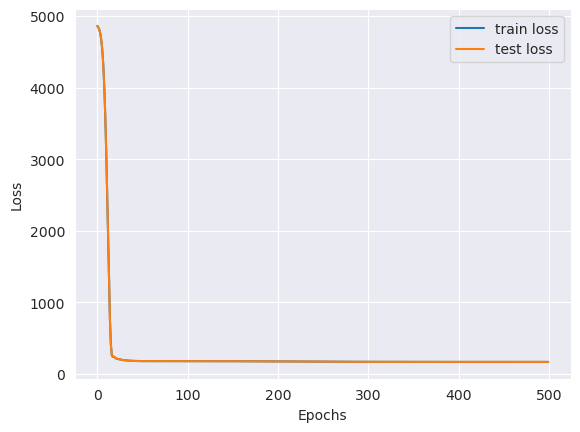

In [142]:
# plot train and test losses
plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

## Comparing with sklearn linear regression model

In [143]:
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
mean_squared_error(y_test, y_pred)

168.12584

In [144]:
y_pred_nn = model(X_test)
mean_squared_error(y_test, y_pred_nn.detach())

169.49864

With Pytorch model we got the same MSE as with sklearn linear regression model and keras model. And the amount of efforts to implement these models was significantly different (Pytorch >> keras > sklearn).

### Questions
1. What preprocessing techniques did you use? Why?
    - One-hot encoding for categorical features. I used one-hot encoding because it is the most common way to encode categorical features.
    - Data separation into a train and test sets. I used this technique because it is the most common way to evaluate the performance of the model.
        - I used 80% of data for training and 20% for testing.
    - Data separating into goal function and features.
2. Describe the fine-tuning process and how you reached your model architecture.
    - In this case we solve regression task, so I used MSE loss function and Adam optimizer.

    - This regression task nicely fits to the linear regression model. And NN with the only 1 hidden layer is also a linear regression model. So I started with the linear regression model and then added more hidden layers.

    - I used 2 hidden layers with 64 neurons in each layer. I used 64 neurons because it is the most common number of neurons in the hidden layer.

    - ReLU activation function was used in the hidden layers. It was used as a most common activation function in the hidden layers.

    - Early stopping was used to prevent overfitting. I used early stopping with patience 100. It means that if the validation loss doesn't decrease for 100 epochs, the training process will be stopped.

    - Learning rate scheduler was used to decrease learning rate after 250 epochs. It was used to better converge to the minimum of the loss function.

    - I used batch size 128. It was used to speed up the training process.

# Task 2: CNN (40%)
For this task, you will be doing image classification:
- First, adapt your best model from Task 1 to work on this task, and
fit it on the new data. Then, evaluate its performance.
- After that, build a CNN model for image classification.
- Compare both models in terms of accuracy, number of parameters and speed of
inference (the time the model takes to predict 50 samples).

For the given data, you need to do proper data preprocessing and augmentation,
data loaders.
Then fine-tune your model architecture (number of layers, number of filters,
activation function, learning rate, momentum, regularization).

### Data
You will be working with the data in `triple_mnist.zip` for predicting 3-digit
numbers writen in the image. Each image contains 3 digits similar to the
following example (whose label is `039`):

![example](https://github.com/shaohua0116/MultiDigitMNIST/blob/master/asset/examples/039/0_039.png?raw=true)

## Create a pytorch dataset from the ImageFolder

In [145]:
# from torchvision import transforms
test_transform = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])


train_data = datasets.ImageFolder(root='triple_mnist/train', transform=test_transform)
test_data = datasets.ImageFolder(root='triple_mnist/test', transform=test_transform)

Trying to get some picture from the dataset, and its label.

('triple_mnist/train/190/20_190.png', 123)


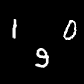

In [146]:
f = train_data.loader
print(train_data.samples[12312])
f(train_data.samples[12312][0])

We can see that the label doesn't match the image. So we need to fix it.

In [147]:
# function for getting the label from the image name
def create_label(path):
    return int(path.split('/')[-1].split('_')[1].split('.')[0])

# fix the labels on the train and test datasets
train_data.samples = [(path, create_label(path)) for path, _ in train_data.samples]
test_data.samples = [(path, create_label(path)) for path, _ in test_data.samples]

## Create data loaders with batch size 16 and shuffle

In [148]:
batch_size = 16

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

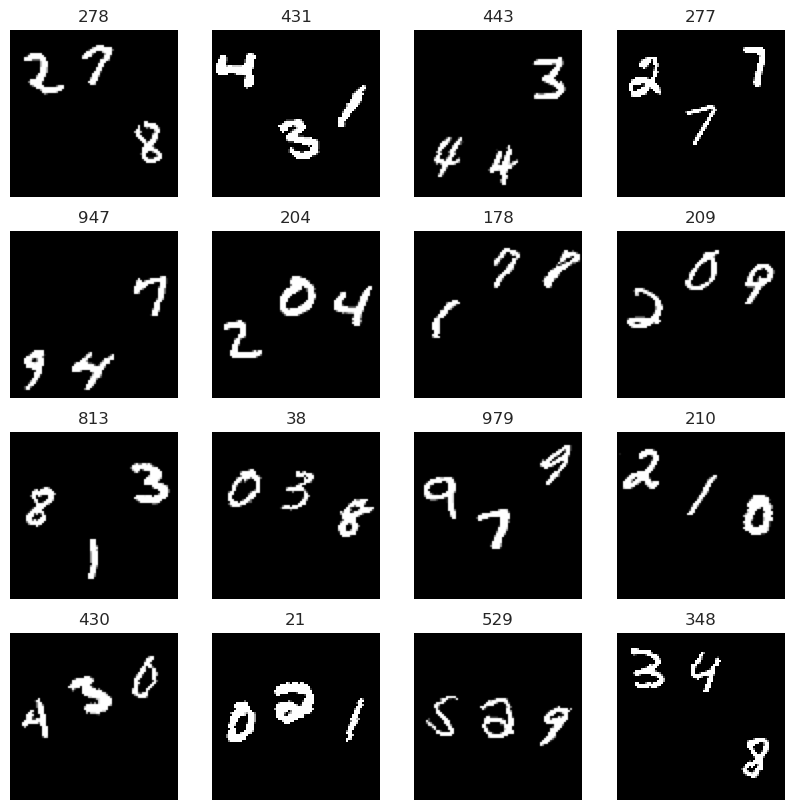

In [149]:
# checking the data
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(train_loader)
images, labels = next(dataiter)

# show images from some batch and its labels
fig, ax = plt.subplots(4, 4, figsize=(10, 10))
for i in range(4):
    for j in range(4):
        ax[i, j].imshow(images[i*4+j].permute(1, 2, 0))
        ax[i, j].set_title(labels[i*4+j].item())
        ax[i, j].axis('off')
        ax[i, j].set_title(labels[i*4+j].item())
        ax[i, j].axis('off')

Now we can see that the labels match the images.

In [150]:
# get shape of the batch of images
image_sample, label_sample = next(iter(train_loader))
image_sample.shape, label_sample.shape

(torch.Size([16, 3, 84, 84]), torch.Size([16]))

## Creating an ANN model from the previous task for this one.

In [151]:
triple_mnist_ann = ANN(3 * 84 * 84, 512, 256, 30, regression=False).to(device)
torchsummary.summary(triple_mnist_ann, (3 * 84 * 84,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 512]      10,838,528
            Linear-2                  [-1, 256]         131,328
            Linear-3                   [-1, 30]           7,710
Total params: 10,977,566
Trainable params: 10,977,566
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.08
Forward/backward pass size (MB): 0.01
Params size (MB): 41.88
Estimated Total Size (MB): 41.96
----------------------------------------------------------------


## Parameters for the training process of the ANN model

In [152]:
epochs = 5
lr = 0.01
log_interval = 100
momentum = 0.5
optimizer = torch.optim.SGD(triple_mnist_ann.parameters(), lr=lr, momentum=momentum)
criterion = nn.NLLLoss()

In [153]:
# function for breaking the 3-digit number into 3 numbers to predict them separately.
f = lambda x: torch.Tensor([torch.div(x,100, rounding_mode='floor'),
                            torch.div((x % 100), 10, rounding_mode='floor'),
                            x % 10]).long()
# inverse function for getting the 3-digit number from 3 numbers.
f_inverse = lambda x: x[0]*100 + x[1]*10 + x[2]

In [154]:
# test_losses = []
# train_losses = []

# training loop (almost the same as in the previous task)
def train_model(model, device, train_loader, optimizer, epoch, criterion, convolutional=False):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):

        data, target = data.to(device), target.to(device)

        if not convolutional:
            data = data.view(-1, 3*84*84)

        optimizer.zero_grad()
        output = model(data)

        output = output.view(data.shape[0], 10, -1)
        target = list(map(f, target))
        target = torch.stack(target).to(device)

        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    # train_losses.append(loss.item())
    return loss.item()

# a testing loop (almost the same as in the previous task)
def test_model(model, device, test_loader, convolutional=False):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)

            if not convolutional:
                data = data.view(-1, 3*84*84)

            output = model(data)

            output = output.view(data.shape[0], 10, -1)
            target = list(map(f, target))
            target = torch.stack(target).to(device)

            test_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).all(dim=2).sum().item()

    test_loss /= len(test_loader)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    # test_losses.append(test_loss)
    return test_loss, correct / len(test_loader.dataset)

In [155]:
# The block for loading the pretrained model state dict. (for faster testing the code)
pretrained = False
# if not pretrained:
#     try:
#         triple_mnist_ann.load_state_dict(torch.load('triple_mnist_model.pt'))
#         pretrained = True
#     except FileNotFoundError:
#         print('No pretrained model found')

In [156]:
# training and testing the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

test_losses = []
train_losses = []

if not pretrained:
    for epoch in range(1, epochs + 1):
        train_losses.append(train_model(triple_mnist_ann, device, train_loader, optimizer, epoch, criterion))
        test_losses.append(test_model(triple_mnist_ann, device, test_loader)[0])

Train Epoch: 1 [0/64000 (0%)]	Loss: 3.407948
Train Epoch: 1 [1600/64000 (2%)]	Loss: 3.391367
Train Epoch: 1 [3200/64000 (5%)]	Loss: 3.367386
Train Epoch: 1 [4800/64000 (8%)]	Loss: 3.322540
Train Epoch: 1 [6400/64000 (10%)]	Loss: 3.311833
Train Epoch: 1 [8000/64000 (12%)]	Loss: 3.160678
Train Epoch: 1 [9600/64000 (15%)]	Loss: 3.271657
Train Epoch: 1 [11200/64000 (18%)]	Loss: 3.070656
Train Epoch: 1 [12800/64000 (20%)]	Loss: 3.161700
Train Epoch: 1 [14400/64000 (22%)]	Loss: 3.149158
Train Epoch: 1 [16000/64000 (25%)]	Loss: 3.027628
Train Epoch: 1 [17600/64000 (28%)]	Loss: 3.014434
Train Epoch: 1 [19200/64000 (30%)]	Loss: 3.040097
Train Epoch: 1 [20800/64000 (32%)]	Loss: 3.156693
Train Epoch: 1 [22400/64000 (35%)]	Loss: 3.067024
Train Epoch: 1 [24000/64000 (38%)]	Loss: 3.033070
Train Epoch: 1 [25600/64000 (40%)]	Loss: 2.911924
Train Epoch: 1 [27200/64000 (42%)]	Loss: 3.114523
Train Epoch: 1 [28800/64000 (45%)]	Loss: 3.241387
Train Epoch: 1 [30400/64000 (48%)]	Loss: 3.082412
Train Epoch: 1

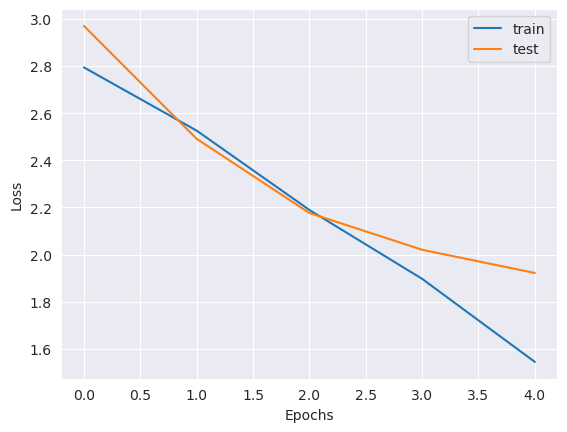

In [157]:
# plot graph of the loss function for the train and test datasets for each epoch.
if not pretrained:
    plt.plot(train_losses, label='train')
    plt.plot(test_losses, label='test')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [158]:
# get final accuracy of the model in the test dataset
final_accuracy_ann =  test_model(triple_mnist_ann, device, test_loader)


Test set: Average loss: 1.9193, Accuracy: 8554/20000 (43%)



In [159]:
# save the model state dict
torch.save(triple_mnist_ann.state_dict(), 'triple_mnist_model.pt')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


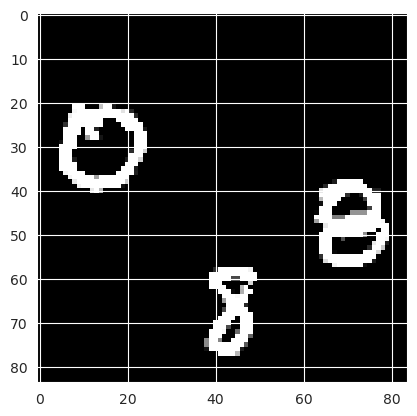

tensor(88, device='cuda:0')
tensor([[[0, 8, 8]]], device='cuda:0')


In [160]:
# check the model on some images from the test dataset
def test_sample(model, device, loader, flatten=False):
    model.eval()
    with torch.no_grad():
        for data, target in loader:
            data, target = data.to(device), target.to(device)
            i = 0
            sample = data[i]
            if flatten:
                sample = sample.view(-1, 3*84*84)
            imshow(sample.view(3, 84, 84).to('cpu'))
            print(target[i])

            if flatten:
                output = model(sample)
                output = output.view(sample.shape[0], 10, -1)
                print(output.argmax(dim=1, keepdim=True))
            else:
                output = model(data)
                output = output.view(data.shape[0], 10, -1)
                output = output.argmax(dim=1, keepdim=True)[i]
                output = output[0][0].item() * 100 + output[0][1].item() * 10 + output[0][2].item()
                print('model_answer', output)
            break

test_sample(triple_mnist_ann, device, test_loader, flatten=True)

In [161]:
# class for the CNN model
class CNN(nn.Module):
    def __init__(self, input_size, output_size):
        super(CNN, self).__init__()
        self.input_size = input_size
        self.output_size = output_size

        # convolutional layers
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=64, kernel_size=3)
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)

        # linear layers
        self.fc1 = nn.Linear(64*8*8, 1024)
        self.fc2 = nn.Linear(1024, 128)
        self.fc3 = nn.Linear(128, 84)
        self.fc4 = nn.Linear(84, output_size)

    def forward(self, x):
        # x.shape = (batch_size, 3, 84, 84)
        x = self.pool(F.relu(self.conv1(x))) # (batch_size, 6, 40, 40)
        x = self.pool(F.relu(self.conv2(x))) # (batch_size, 16, 18, 18)
        x = self.pool(F.relu(self.conv3(x))) # (batch_size, 32, 8, 8)
        # print(x.shape)
        x = F.relu(self.conv4(x)) # (batch_size, 64, 8, 8)

        x = x.view(-1, 64 * 8 * 8)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        x = F.log_softmax(x, dim=1)

        return x

In [163]:
# model parameters
triple_mnist_cnn = CNN(3 * 84 * 84, 30).to(device)
lr = 0.01
momentum = 0.5
log_interval = 100
optimizer = torch.optim.SGD(triple_mnist_cnn.parameters(), lr=lr, momentum=momentum)
criterion = nn.NLLLoss()
epochs = 5

In [164]:
# load model if needed
pretrained = False
# try:
#     triple_mnist_cnn.load_state_dict(torch.load('cnn_model.pt'))
#     print('Model loaded')
#     pretrained = True
# except FileNotFoundError:
#     print('No model found')

In [179]:
# train and test the CNN model
if not pretrained:
    train_losses = []
    test_losses = []
    for epoch in range(1, epochs + 1):
        train_losses.append(train_model(triple_mnist_cnn, device, train_loader, optimizer, epoch, criterion, convolutional=True))
        test_losses.append(test_model(triple_mnist_cnn, device, test_loader, convolutional=True)[0])

Train Epoch: 1 [0/64000 (0%)]	Loss: 1.212581
Train Epoch: 1 [1600/64000 (2%)]	Loss: 1.316152
Train Epoch: 1 [3200/64000 (5%)]	Loss: 1.255985
Train Epoch: 1 [4800/64000 (8%)]	Loss: 1.257469
Train Epoch: 1 [6400/64000 (10%)]	Loss: 1.172684
Train Epoch: 1 [8000/64000 (12%)]	Loss: 1.329085
Train Epoch: 1 [9600/64000 (15%)]	Loss: 1.267904
Train Epoch: 1 [11200/64000 (18%)]	Loss: 1.215533
Train Epoch: 1 [12800/64000 (20%)]	Loss: 1.230460
Train Epoch: 1 [14400/64000 (22%)]	Loss: 1.239328
Train Epoch: 1 [16000/64000 (25%)]	Loss: 1.301787
Train Epoch: 1 [17600/64000 (28%)]	Loss: 1.196046
Train Epoch: 1 [19200/64000 (30%)]	Loss: 1.235964
Train Epoch: 1 [20800/64000 (32%)]	Loss: 1.228757
Train Epoch: 1 [22400/64000 (35%)]	Loss: 1.261125
Train Epoch: 1 [24000/64000 (38%)]	Loss: 1.215832
Train Epoch: 1 [25600/64000 (40%)]	Loss: 1.165231
Train Epoch: 1 [27200/64000 (42%)]	Loss: 1.516785
Train Epoch: 1 [28800/64000 (45%)]	Loss: 1.255696
Train Epoch: 1 [30400/64000 (48%)]	Loss: 1.145637
Train Epoch: 1

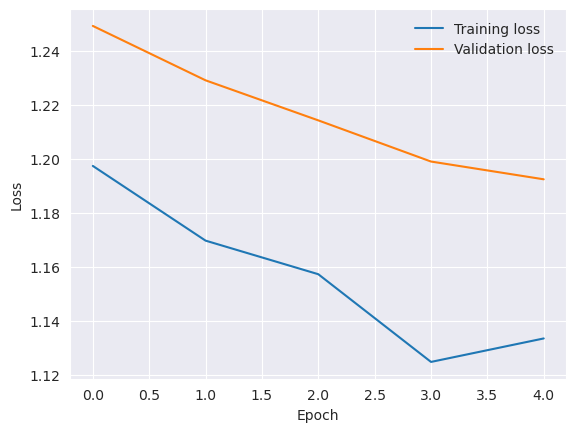

In [181]:
if not pretrained:
# graph the loss
    plt.plot(train_losses, label='Training loss')
    plt.plot(test_losses, label='Validation loss')
    plt.legend(frameon=False)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()

In [185]:
final_accuracy_cnn = test_model(triple_mnist_cnn, device, test_loader, convolutional=True)


Test set: Average loss: 1.1928, Accuracy: 18650/20000 (93%)



In [168]:
# save the model
torch.save(triple_mnist_cnn.state_dict(), 'cnn_model.pt')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


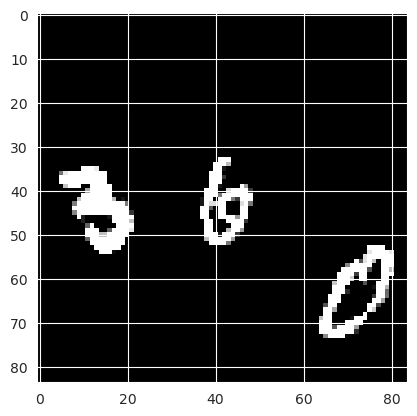

tensor(360, device='cuda:0')
model_answer 360


In [169]:
# test the model on a random image
test_sample(triple_mnist_cnn, device, test_loader)

## Compare both models in terms of accuracy, number of parameters and speed of inference (the time the model takes to predict 50 samples).

In [187]:
# compare the models accuracy
print("ANN accuracy on the test set: ", final_accuracy_ann[1])
print("CNN accuracy on the test set: ", final_accuracy_cnn[1])

ANN accuracy on the test set:  0.4277
CNN accuracy on the test set:  0.9325


In [188]:
# compare the models number of parameters
print("ANN number of parameters: ", sum(p.numel() for p in triple_mnist_ann.parameters()))
print("CNN number of parameters: ", sum(p.numel() for p in triple_mnist_cnn.parameters()))

ANN number of parameters:  10977566
CNN number of parameters:  4388994


In [189]:
def model_answer(model, device, sample):
    model.eval()
    with torch.no_grad():
        sample = sample.to(device)
        output = model(sample)
        output = output.view(1, 10, -1)
        return output.argmax(dim=1, keepdim=True)

In [190]:
# get random samples from the test set
test_samples = []
test_labels = []
for j in range(4):
    for data, target in test_loader:
        for i in range(data.shape[0]):
            test_samples.append(data[i])
            test_labels.append(target[i])
        break
test_samples = test_samples[:50]
test_labels = test_labels[:50]

In [191]:
%%timeit
# compare the models inference time
for i in range(50):
    model_answer(triple_mnist_ann, device, test_samples[i].view(-1, 3* 84 * 84))


15.6 ms ± 298 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [192]:
%%timeit
for i in range(50):
    model_answer(triple_mnist_cnn, device, test_samples[i].view(-1, 3, 84, 84))

34.7 ms ± 3.24 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


### Questions
1. What preprocessing techniques did you use? Why?
    - Creating data loaders for the train and test sets with batch size of 16.
    - Shuffling the train and test sets.
    - Redefining labels for the data in the dataloaders.
2. What data augmentation techniques did you use?
    - Normalizing the data.
    - Randomly rotating the images by 10 degrees.
3. Describe the fine-tuning process and how you reached your final CNN model.
    - Firstly I tried to make CNN model with 1000 classes in the output layer, but it didn't work well.
    - Then I decided to make model with 30 neurons in the output layer (10 neurons for each digit in the label). And this approach worked much better.
    - Then I tried to add more layers to the model to improve the accuracy.
    - In final model I have 4 convolutional layers with ReLU activation function.
    - After each convolutional layer, except the last one, I have max pooling layer.
    - Finally, after all the convolutional layers my input takes the form of (batch_size, 64, 8, 8).
    - Then I flatten the input and pass it to the fully connected layer with 30 neurons in the output layer.
- And about the training process:
    - I used SGD optimizer with learning rate of 0.01 and momentum of 0.5.
    - I used NLLLoss as a loss function.
    - I trained the model for 15 epochs.
This model have pretty good accuracy on the test set (about 94%). And I think these parameters and architecture of the model are good enough for this task.

# Task 3: Decision Trees and Ensemble Learning (15%)

For the `loan_data.csv` data, predict if the bank should give a loan or not.
You need to do the following:
- Fine-tune a decision tree on the data
- Fine-tune a random forest on the data
- Compare their performance
- Visualize your DT and one of the trees from the RF

For evaluating your models, do $80/20$ train test split.

### Data
- `credit.policy`: Whether the customer meets the credit underwriting criteria.
- `purpose`: The purpose of the loan.
- `int.rate`: The interest rate of the loan.
- `installment`: The monthly installments owed by the borrower if the loan is funded.
- `log.annual.inc`: The natural logarithm of the self-reported annual income of the borrower.
- `dti`: The debt-to-income ratio of the borrower.
- `fico`: The FICO credit score of the borrower.
- `days.with.cr.line`: The number of days the borrower has had a credit line.
- `revol.bal`: The borrower's revolving balance.
- `revol.util`: The borrower's revolving line utilization rate.

In [46]:
loan_data = pd.read_csv('loan_data.csv')
print(loan_data.shape)
loan_data.head()

(9578, 14)


,credit.policy,purpose,int.rate,installment,log.annual.inc,dti,fico,days.with.cr.line,revol.bal,revol.util,inq.last.6mths,delinq.2yrs,pub.rec,not.fully.paid
0,1,debt_consolidation,0.1189,829.10,11.350407,19.48,737,5639.958333,28854,52.1,0,0,0,0
1,1,credit_card,0.1071,228.22,11.082143,14.29,707,2760.000000,33623,76.7,0,0,0,0
2,1,debt_consolidation,0.1357,366.86,10.373491,11.63,682,4710.000000,3511,25.6,1,0,0,0
3,1,debt_consolidation,0.1008,162.34,11.350407,8.10,712,2699.958333,33667,73.2,1,0,0,0
4,1,credit_card,0.1426,102.92,11.299732,14.97,667,4066.000000,4740,39.5,0,1,0,0


In [47]:
loan_data_purpose = pd.get_dummies(loan_data['purpose'])
loan_data = loan_data.drop('purpose', axis=1)
loan_data = pd.concat([loan_data, loan_data_purpose], axis=1)
loan_data.head()

,credit.policy,int.rate,installment,log.annual.inc,dti,fico,days.with.cr.line,revol.bal,revol.util,inq.last.6mths,delinq.2yrs,pub.rec,not.fully.paid,all_other,credit_card,debt_consolidation,educational,home_improvement,major_purchase,small_business
0,1,0.1189,829.10,11.350407,19.48,737,5639.958333,28854,52.1,0,0,0,0,0,0,1,0,0,0,0
1,1,0.1071,228.22,11.082143,14.29,707,2760.000000,33623,76.7,0,0,0,0,0,1,0,0,0,0,0
2,1,0.1357,366.86,10.373491,11.63,682,4710.000000,3511,25.6,1,0,0,0,0,0,1,0,0,0,0
3,1,0.1008,162.34,11.350407,8.10,712,2699.958333,33667,73.2,1,0,0,0,0,0,1,0,0,0,0
4,1,0.1426,102.92,11.299732,14.97,667,4066.000000,4740,39.5,0,1,0,0,0,1,0,0,0,0,0


In [48]:
X = loan_data.drop('credit.policy', axis=1)
y = loan_data['credit.policy']

In [49]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

The best metric for this problem is recall. We want to minimize the number of people who are not eligible for a loan but are given one. This is a very important metric for banks.

In [50]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

dtree_clf = DecisionTreeClassifier() # decision tree classifier

# parameters for grid search
params = {
    'max_depth': [2, 3, 4, 5, 6, 7],
    'min_samples_split': [4, 5, 6, 7],
    'min_samples_leaf': [4, 5, 6, 7, 8, 9, 10],
    'max_features': ['sqrt', 'log2'],
    'criterion': ['gini', 'entropy']
}

# grid search with 5-fold cross validation
grid_search = GridSearchCV(dtree_clf, params, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

# best parameters
best_model = grid_search.best_estimator_

# accuracy on test set
y_pred = best_model.predict(X_test)
print('Accuracy: ', accuracy_score(y_test, y_pred))

Accuracy:  0.9749478079331941


In [51]:
grid_search.best_params_ # best parameters

{'criterion': 'entropy',
 'max_depth': 7,
 'max_features': 'sqrt',
 'min_samples_leaf': 6,
 'min_samples_split': 6}

In [52]:
rf_clf = RandomForestClassifier() # random forest classifier

# parameters for grid search
params_rf = {
    'n_estimators': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
    'max_depth': [2, 4, 6, 5, 7],
    'min_samples_split': [2, 4, 6, 5],
    'min_samples_leaf': [2, 4, 6, 5],
    'max_features': ['sqrt', 'log2'],
    'criterion': ['gini', 'entropy']
}

# grid search with 5-fold cross validation
grid_search_rf = GridSearchCV(rf_clf, params_rf, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)
grid_search_rf.fit(X_train, y_train)

# best parameters
y_pred_rf = grid_search_rf.predict(X_test)

# accuracy on test set
print('Accuracy: ', accuracy_score(y_test, y_pred_rf))

Fitting 5 folds for each of 3200 candidates, totalling 16000 fits
Accuracy:  0.9838204592901879


In [53]:
grid_search_rf.best_params_ # best parameters

{'criterion': 'entropy',
 'max_depth': 7,
 'max_features': 'sqrt',
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 60}

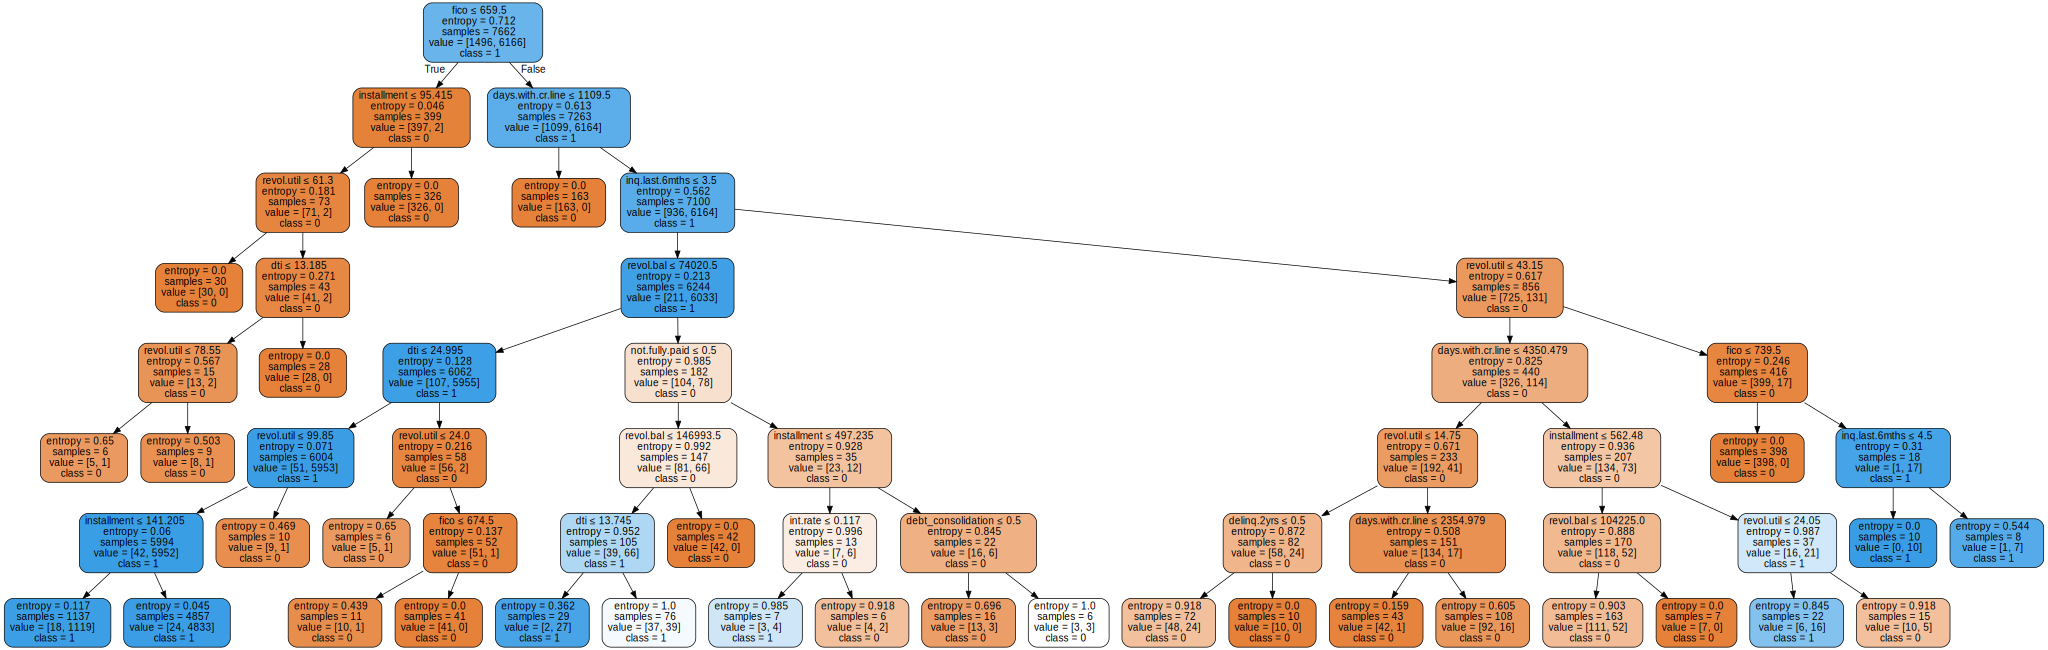

In [54]:
from sklearn.tree import export_graphviz
import graphviz

# visualize decision tree
dot_data = export_graphviz(best_model, out_file=None,
                           feature_names=X.columns,
                           class_names=['0', '1'],
                           filled=True, rounded=True,
                           special_characters=True)
graph = graphviz.Source(dot_data)
graph

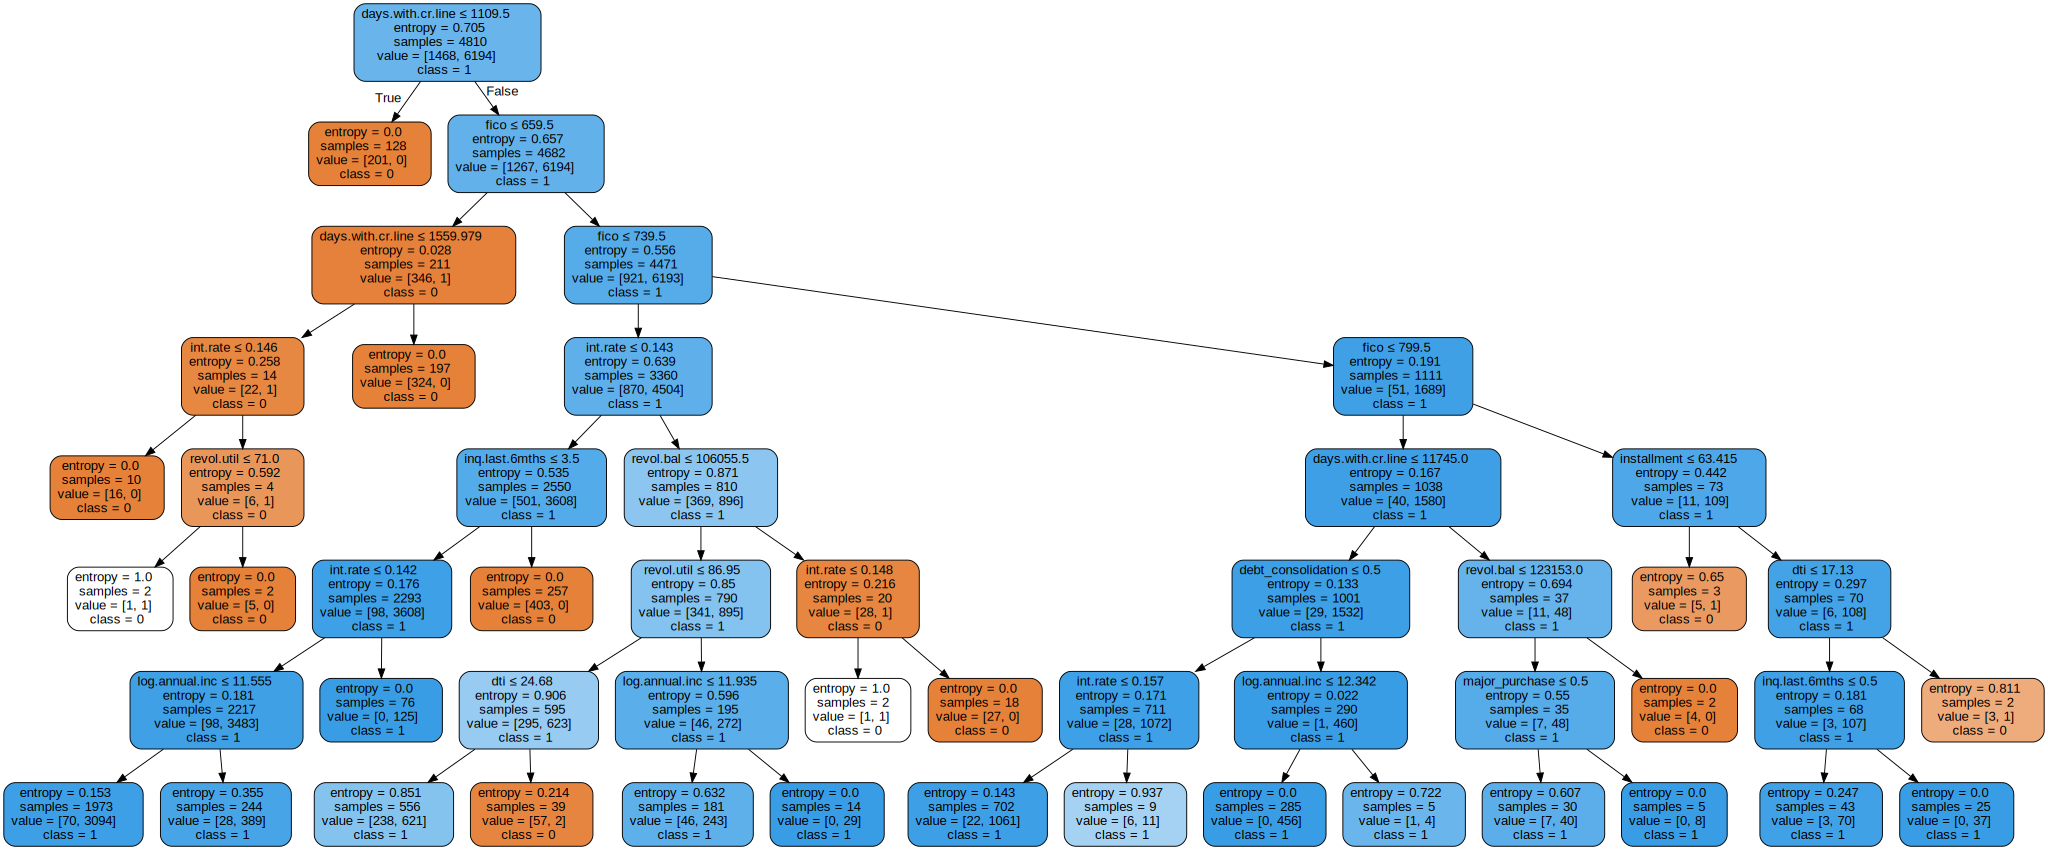

In [55]:
rf_clf = grid_search_rf.best_estimator_

# visualize some tree from random forest
dot_data = export_graphviz(rf_clf.estimators_[0], out_file=None,
                           feature_names=X.columns,
                           class_names=['0', '1'],
                           filled=True, rounded=True,
                           special_characters=True)
graph = graphviz.Source(dot_data)
graph

### Questions
1. How did the DT compare to the RF in performance? Why?
    - DT has worse performance than RF. RF is an ensemble of DTs, so it is more powerful than a single DT. Also, RF is less prone to overfitting.
2. After fine-tuning, how does the max depth in DT compare to RF? Why?
    - The max depth in DT is 6, while in RF it is 7. DT is more prone to overfitting, so it has a smaller max depth after cross validation.
3. What is ensemble learning? What are its pros and cons?
    - Pros:
        - Ensemble learning is more powerful than a single model.
        - Ensemble learning is less prone to overfitting.
    - Cons:
        - Ensemble learning is more computationally expensive.
        - Ensemble learning is harder to interpret.
4. Briefly explain 2 types of boosting methods and 2 types of bagging methods.
Which of these categories does RF fall under?
    - Boosting methods:
        - AdaBoost - Boosting method that uses decision trees as weak learners. It is a sequential method, where each tree is trained on the weighted data from the previous tree. The weights are updated after each tree is trained. The final prediction is the weighted average of the predictions of all the trees.
        - Gradient Boosting - Boosting method that uses decision trees as weak learners. It is also a sequential method, where each tree is trained on the residuals from the previous tree. The final prediction is the sum of the predictions of all the trees.
    - Bagging methods:
        - Bootstrap Aggregation—this method just consists of averaging the predictions of multiple models. These models are trained on different subsets of the data.
        - Bagging—this method is like bootstrap aggregation, but the models are trained on different subsets of the features.
    - Random Forest is a bootstrap aggregation method.

# Task 4: Domain Gap (15%)

Evaluate your CNN model from task 2 on SVHN data without retraining your model.

In [56]:
import os
import torchvision.io as io
svhn_dir = 'svhn/'

data = []
labels = []
for file in (os.listdir(svhn_dir)):
    if file.endswith('.png'):
        img_data = io.read_image(svhn_dir + file)
        data.append(img_data)
        labels.append(file)
# for sample in data:
#     print(sample.shape)
# data = torch.stack(data)
# data.shape

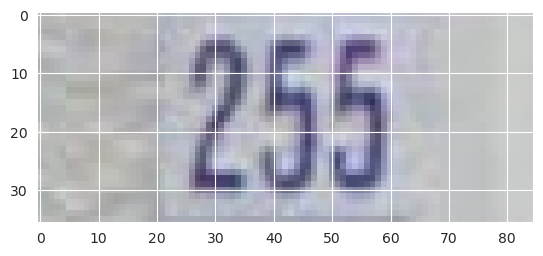

255.png


In [57]:
imshow(data[5].to('cpu'))
print(labels[5])

In [76]:
print(data[0][2])

tensor([[109, 117, 128,  ..., 117, 110, 108],
        [113, 123, 131,  ..., 120, 116, 112],
        [118, 127, 133,  ..., 123, 120, 119],
        ...,
        [141, 144, 148,  ..., 117, 118, 116],
        [142, 144, 148,  ..., 117, 116, 116],
        [144, 146, 148,  ..., 117, 118, 117]], dtype=torch.uint8)


In [58]:
import torchvision.transforms as T
data_tensors = []

data_transform = T.Compose([
    T.ToPILImage(),
    T.Resize((32, 32)),
    T.ToTensor(),
    T.Normalize((0.5,), (0.5,))
])

for file in data:
    data_tensors.append(data_transform(file))

data_tensors = torch.stack(data_tensors)


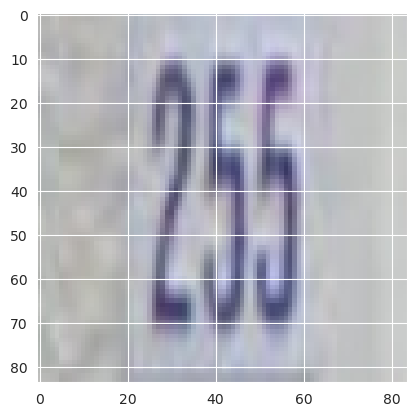

255.png


In [59]:
imshow(data_tensors[5].to('cpu'))
print(labels[5])

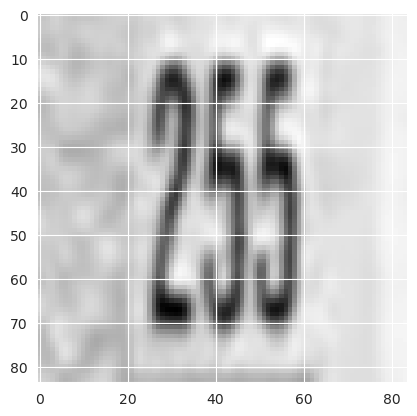

In [60]:
from scipy import ndimage
some_image = data_tensors[5]

grey_image = torch.mean(some_image, dim=0)
# make image sharper
sharpened_image = ndimage.gaussian_filter(grey_image, sigma=1)
plt.imshow(sharpened_image, cmap='gray')

In [61]:
for i, sample in enumerate(data_tensors):
    # print(sample.shape)
    output = triple_mnist_cnn(data_tensors[i].to(device))
    # print(output.shape)
    output = output.view(1, 10, -1)
    # print(output.shape)
    print(output.argmax(dim=1, keepdim=True))
    print(labels[i])
    # imshow(sample.to('cpu'))
    print('-------------')
    # break

tensor([[[1, 1, 1]]], device='cuda:0')
138.png
-------------
tensor([[[1, 1, 4]]], device='cuda:0')
701.png
-------------
tensor([[[1, 1, 4]]], device='cuda:0')
708.png
-------------
tensor([[[1, 1, 4]]], device='cuda:0')
910.png
-------------
tensor([[[1, 1, 1]]], device='cuda:0')
203.png
-------------
tensor([[[1, 1, 1]]], device='cuda:0')
255.png
-------------
tensor([[[1, 4, 4]]], device='cuda:0')
754.png
-------------
tensor([[[1, 4, 4]]], device='cuda:0')
150.png
-------------
tensor([[[1, 4, 4]]], device='cuda:0')
402.png
-------------
tensor([[[1, 1, 4]]], device='cuda:0')
282.png
-------------
tensor([[[1, 1, 4]]], device='cuda:0')
148.png
-------------
tensor([[[1, 1, 4]]], device='cuda:0')
380.png
-------------
tensor([[[1, 1, 4]]], device='cuda:0')
205.png
-------------
tensor([[[1, 1, 4]]], device='cuda:0')
995.png
-------------
tensor([[[1, 1, 4]]], device='cuda:0')
505.png
-------------
tensor([[[1, 1, 4]]], device='cuda:0')
174.png
-------------
tensor([[[1, 1, 4]]], de

### Questions
1. How did your model perform? Why is it better/worse?
    - *Answer*
2. What is domain gap in the context of ML?
    - *Answer*
3. Suggest two ways through which the problem of domain gap can be tackled.
    - *Answer*